In [34]:
from glob import glob
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import pickle
import datetime
import random
import re

In [36]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Data taken from the article http://ceur-ws.org/Vol-1703/paper12.pdf

The data itself: http://fc.isima.fr/~kahngi/cez13.zip

In [37]:
# Progress tracker from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [3]:
# Auxillary function to assign site idexes
def sitefreq(sites, site_freq={}):
    if len(site_freq):
        site_id = max(site_freq.items(), key=lambda t: t[1][0])[1][0] + 1
    else:
        site_id = 1
        
    for site in sites:
        if site not in site_freq:
            site_freq[site] = [site_id, 1]
            site_id += 1
        else:
            site_freq[site][1] += 1
            
    return site_freq

In [4]:
# Assigns every website a unique index and counts the number of its appearance
def prepare_site_indexes(csv_files_mask, user_filter=[]):
    for userfile in log_progress(glob(csv_files_mask), every=1):
        user_id = int(re.search('cat(\d+)\.csv', userfile).group(1))
        if len(user_filter) and user_id not in user_filter: continue     
        
        data = pd.read_csv(userfile, sep=";", header=None, \
                           names=['userid', 'timestamp', 'site'])      
        site_freq = sitefreq(data.site)
    return site_freq

In [5]:
%%time
site_index = prepare_site_indexes('dispoSite/allcats/cat*.csv')
pd.DataFrame([[v[0], k]for k, v in sorted(site_index.items(), \
            key=lambda x: x[1][0])])\
            .to_csv("new_kaggle_data/site_indexes.txt", header=False, index=False)

CPU times: user 1min 26s, sys: 332 ms, total: 1min 27s
Wall time: 1min 27s


In [14]:
%%time
users=pd.read_csv("new_kaggle_data_550/users.csv", header=None, names=["user_id"])
site_index_550 = prepare_site_indexes('dispoSite/allcats/cat*.csv', \
                 user_filter=users.as_matrix().flatten().tolist())
pd.DataFrame([[v[0], k]for k, v in sorted(site_index_550.items(), \
            key=lambda x: x[1][0])])\
            .to_csv("new_kaggle_data_550/site_indexes.txt", header=False, index=False)

CPU times: user 16.1 s, sys: 1.56 s, total: 17.7 s
Wall time: 15.9 s


In [5]:
#Randomly increment a date (year, month, day) preserving the weekday
weekday = lambda x: x.isoweekday()

def increment_date(date, seed):
    one_day = datetime.timedelta(days=1)
    one_month = datetime.timedelta(days=30)
    one_year = datetime.timedelta(days=365)
    random.seed(seed)
    r = random.sample(range(1, 10), 3)
    
    newdate = date + r[0]*one_year + r[1]*one_month + r[2]*one_day
    while weekday(newdate) != weekday(date):
        newdate += one_day
    return newdate

In [14]:
%%time
#Tried to count the dates frequencies in each of the csv files.
dates_dict = {}
for userfile in log_progress(glob("dispoSite/allcats/cat*.csv"), every=1):
    # Reading every file and sorting by timestamp
    user_id = int(re.search('cat(\d+)\.csv', userfile).group(1))

    data = pd.read_csv(userfile, sep=";", header=None, \
                       names=['userid', 'timestamp', 'site'], \
                       parse_dates=[1], infer_datetime_format=True)
    data.sort_values("timestamp", inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    data["date"] = data["timestamp"].apply(lambda x: datetime.date(x.year, x.month, x.day))
    
    for date in np.unique(data["date"].values):
        if date in dates_dict:
            dates_dict[date] +=1
        else:
            dates_dict[date] = 1

CPU times: user 2min 19s, sys: 996 ms, total: 2min 20s
Wall time: 2min 19s


In [28]:
dates = pd.DataFrame(dates_dict.items())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cb9bbfe10>]], dtype=object)

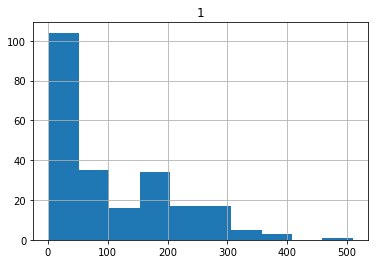

In [38]:
dates.hist()

In [25]:
sorted(dates_dict.items(), key = lambda x: x[1], reverse=True)

[(datetime.date(2014, 5, 13), 510),
 (datetime.date(2014, 4, 24), 394),
 (datetime.date(2014, 2, 26), 376),
 (datetime.date(2014, 4, 14), 376),
 (datetime.date(2014, 3, 19), 345),
 (datetime.date(2014, 4, 2), 317),
 (datetime.date(2014, 4, 16), 314),
 (datetime.date(2014, 4, 23), 313),
 (datetime.date(2014, 4, 22), 310),
 (datetime.date(2014, 5, 12), 299),
 (datetime.date(2014, 2, 19), 298),
 (datetime.date(2013, 11, 25), 294),
 (datetime.date(2014, 2, 13), 293),
 (datetime.date(2014, 4, 25), 292),
 (datetime.date(2014, 2, 12), 287),
 (datetime.date(2014, 3, 17), 286),
 (datetime.date(2014, 3, 20), 277),
 (datetime.date(2014, 4, 17), 272),
 (datetime.date(2014, 2, 27), 267),
 (datetime.date(2013, 11, 19), 261),
 (datetime.date(2014, 1, 29), 261),
 (datetime.date(2014, 2, 25), 260),
 (datetime.date(2014, 3, 26), 259),
 (datetime.date(2014, 3, 31), 259),
 (datetime.date(2013, 12, 18), 257),
 (datetime.date(2014, 4, 18), 256),
 (datetime.date(2014, 4, 15), 248),
 (datetime.date(2014, 3, 1

In [16]:
# Split original dataset into train and test
def prepare_train_test_set(csv_files_mask, dest_folder, ratio=2./3, user_filter=[]):
    for userfile in log_progress(glob(csv_files_mask), every=1):
        # Reading every file and sorting by timestamp
        user_id = int(re.search('cat(\d+)\.csv', userfile).group(1))
        if len(user_filter) and user_id not in user_filter: continue
            
        data = pd.read_csv(userfile, sep=";", header=None, \
                           names=['userid', 'timestamp', 'site'], \
                           parse_dates=[1], infer_datetime_format=True)
        data.sort_values("timestamp", inplace=True)
        data.reset_index(drop=True, inplace=True)

        # Splitting into train and test data using ratio
        train_data = pd.DataFrame(data.iloc[:int(len(data)*ratio)])[["timestamp", "site"]]        
        test_data = pd.DataFrame(data.iloc[int(len(data)*ratio):])[["timestamp", "site"]]
        test_data.reset_index(drop=True, inplace=True)

        # Randomly incrementing dates within test
        seed = random.randint(1, 5000)
        test_data["timestamp"] = test_data.apply(lambda row: increment_date(row["timestamp"], seed), axis=1)

        train_data.to_csv("{}/train/user{}.csv".format(dest_folder, user_id), index=False)
        test_data.to_csv("{}/test/user{}.csv".format(dest_folder, user_id), index=False)

In [141]:
%%time
prepare_train_test_set("dispoSite/allcats/cat*.csv", "new_kaggle_data")

CPU times: user 13min 47s, sys: 2.35 s, total: 13min 49s
Wall time: 13min 46s


In [17]:
%%time
users=pd.read_csv("new_kaggle_data_550/users.csv", header=None, names=["user_id"])
prepare_train_test_set("dispoSite/allcats/cat*.csv", "new_kaggle_data_550", \
                       user_filter=users.as_matrix().flatten().tolist())

CPU times: user 5min 3s, sys: 2.22 s, total: 5min 6s
Wall time: 5min 3s


## Create train and test session files

In [19]:
def get_site_index(csv_file):
    site_index = pd.read_csv(csv_file, header=None, names=['siteid', 'site'], index_col=1)
    site_dic = site_index.to_dict()
    return site_dic["siteid"]

In [23]:
# Creates a file with sessions out of plain logs with websites
def prepare_sessions_set(csv_files_mask, out_folder, site_index_path="", test_sessions = False,
                        session_length=10, window_size=10, session_time = 30,\
                        sort_in_session=False, remove_dups = False, shuffle=True):
    
    col_names = ["site"+str(c) for c in range(1,session_length+1)] + \
                ["time"+str(c) for c in range(1,session_length+1)] + ["user_id"]
    
    ses_data = np.array([np.zeros(len(col_names))])
    test_answers = []
    session_num = 0

    site_index = get_site_index(site_index_path)
    
    files = glob(csv_files_mask)
        
    for userfile in log_progress(files, every=1):
        user_id = re.search('user(\d+)\.csv', userfile).group(1)
        
        data = pd.read_csv(userfile, \
                           parse_dates=[0], infer_datetime_format=True)
        data.sort_values("timestamp", inplace=True)
        data.reset_index(drop=True, inplace=True)

        session_hash = {}    
        
        session = []
        timestamps = []
        next_session = []
        next_t_session = []
        next_s_session = []
        next_timestamps = []

        for i in range (0, len(data), window_size):  
            session += list(data[i:i+session_length].site.apply(lambda x: site_index[x]))
            timestamps += list(data[i:i+session_length].timestamp)

            if window_size < session_length and sort_in_session:
                ses_ts_zip = sorted(set(zip(session, timestamps)), key = lambda t: t[1])
                session, timestamps = zip(*ses_ts_zip)
                session = list(session)
                timestamps = list(timestamps)

            while ((len(session) >= session_length) or (not len(data[i+window_size:]) and len(session))):
                time_diff = [(timestamps[n+1] - timestamps[n]).total_seconds() for n in range(0, len(session)-1)]
                session_timespan = (max(timestamps) - min(timestamps)).total_seconds()
                next_session = []
                next_timestamps = []

                while session_timespan > session_time*60 or len(session) > session_length:
                    next_session.insert(0, session.pop())
                    next_timestamps.insert(0, timestamps.pop())
                    time_diff = [(timestamps[n+1] - timestamps[n]).total_seconds() for n in range(0, len(session)-1)]
                    session_timespan = (max(timestamps) - min(timestamps)).total_seconds()

                session = tuple(session)

                if session not in session_hash or not remove_dups:                      
                    session_hash[session] = 1
                    session = list(session)

                    session.extend([0] * (session_length - len(session)) + \
                                   timestamps + [0] * (session_length - len(timestamps)) + [user_id])

                    ses_data = np.concatenate((ses_data, np.array([session])))
                    session_num += 1

                session = next_session
                timestamps = next_timestamps

        if len(next_session):
            print("ERROR! next_session left!")
            print(session)
            return None

    
    ses_data = np.delete(ses_data, 0, 0)
    if shuffle: np.random.shuffle(ses_data)
    ses_data = pd.DataFrame(ses_data, columns=col_names)
    
    if test_sessions:
        #ses_data.iloc[:,:-1].to_csv(out_folder+"/test_sessions.csv", index=False)
        #ses_data.iloc[:,-1].to_csv(out_folder+"/test_answers.csv", index=False)
        ses_data.to_csv(out_folder+"/test_sessions.csv", index=False)
        return ses_data, test_answers
    else:
        ses_data.to_csv(out_folder+"/train_sessions.csv", index=False)
        return ses_data

In [21]:
%%time
train_data = prepare_sessions_set("new_kaggle_data_550/train/*", out_folder="new_kaggle_data_550", \
                site_index_path="new_kaggle_data_550/site_indexes.txt", remove_dups=True, shuffle=True)

CPU times: user 4min 54s, sys: 384 ms, total: 4min 55s
Wall time: 4min 54s


In [24]:
%%time
test_data, test_answers = prepare_sessions_set("new_kaggle_data_550/test/*", out_folder="new_kaggle_data_550", \
                site_index_path="new_kaggle_data_550/site_indexes.txt", test_sessions=True, remove_dups=True, \
                shuffle=True)

CPU times: user 2min 8s, sys: 344 ms, total: 2min 8s
Wall time: 2min 8s


In [9]:
%%time
train_data = prepare_sessions_set("new_kaggle_data/train/*", out_folder="new_kaggle_data", \
                site_index_path="new_kaggle_data/site_indexes.txt", remove_dups=True, shuffle=True)

CPU times: user 3h 31min 24s, sys: 12min 46s, total: 3h 44min 10s
Wall time: 3h 44min 4s


In [10]:
%%time
test_data, test_answers = prepare_sessions_set("new_kaggle_data/test/*", out_folder="new_kaggle_data", \
                site_index_path="new_kaggle_data/site_indexes.txt", test_sessions=True, remove_dups=True, \
                shuffle=True)

CPU times: user 1h 6min 13s, sys: 3.19 s, total: 1h 6min 16s
Wall time: 1h 6min 14s
